Notes on version:

*   With ChemPy
*   No drop in CO2(g) (assuming infinite supply)
*   CO2(aq) governed by MT
*   [H2CO3] production governed by ChemPy
*   [H2CO3] removal governed by K_carb * [H2CO3] * x
*   Assumes constant pressure of 1 atm
*   Output as time to reach set target mass of captured CO2 as a % of concrete (mass for mass)
*   Output of flow rate CO2 to maintain steady state *** change to average flow rate and plot ***
*   increasing K_carb reduces total time -> problem!



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure ChemPy is installed
try:
    import chempy
except ModuleNotFoundError:
    !pip install chempy
    import chempy

from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction
from chempy import ReactionSystem
from chempy.chemistry import Reaction, Substance

# Constants
R = 8.314  # Universal gas constant, J/(mol·K)
print(f"R: {R} J/(mol·K)")
T = 298.15  # Temperature in Kelvin (25°C)
print(f"T: {T} K")
H_atm = 29.4  # Henry's Law constant for CO2 in water at 25°C, atm·m³/mol
print(f"H_atm: {H_atm} atm·m³/mol")
H_Pa = H_atm * 101325  # Henry's Law constant in Pa·m³/mol
print(f"H_Pa: {H_Pa} Pa·m³/mol")
k = 1e-1  # Mass transfer coefficient, m/s
print(f"k: {k} m/s")
hydration_level = 0.1  # 10%
print(f"hydration_level: {hydration_level}")
rho_concrete = 2400  # Density of concrete, kg/m³
print(f"rho_concrete: {rho_concrete} kg/m³")
rho_water = 1000  # Density of water, kg/m³
print(f"rho_water: {rho_water} kg/m³")
wetting_coefficient = 0.8  # Wetting coefficient
print(f"wetting_coefficient: {wetting_coefficient}")
P_total_atm = 1.0  # Total pressure in atm (standard pressure)
P_total_Pa = P_total_atm * 101325  # Total pressure in Pa (standard pressure)
print(f"P_total_atm: {P_total_atm} atm")
print(f"P_total_Pa: {P_total_Pa} Pa")
percentage_CO2 = 1  # Percentage of CO2 input
print(f"percentage_CO2: {percentage_CO2}")
K_carb = 1  # Define K_carb appropriately
print(f"K_carb: {K_carb} ")

# Rate constants for the reaction CO2 + H2O <-> H2CO3 NATIVE
k_forward = 0.039  # Forward rate constant (1/s)
k_reverse = 23  # Reverse rate constant (1/s)

# Rate constants for the reaction CO2 + H2O <-> H2CO3 CA
#k_forward = .39  # Forward rate constant (1/s)
#k_reverse = 230  # Reverse rate constant (1/s)

#Variables
Reactor_dia = 10  # Insert the diameter of the reactor
Reactor_height = 30  # Insert the height of the reactor

# Calculate the volume of the cylindrical reactor
V = math.pi * (Reactor_dia / 2) ** 2 * Reactor_height

print(f"V: {V:.4g} m³")


R: 8.314 J/(mol·K)
T: 298.15 K
H_atm: 29.4 atm·m³/mol
H_Pa: 2978955.0 Pa·m³/mol
k: 0.1 m/s
hydration_level: 0.1
rho_concrete: 2400 kg/m³
rho_water: 1000 kg/m³
wetting_coefficient: 0.8
P_total_atm: 1.0 atm
P_total_Pa: 101325.0 Pa
percentage_CO2: 1
K_carb: 1 
V: 2356 m³


In [2]:
# Function to calculate total surface area
def calculate_surface_area_normal_distribution(mean_diameter, std_deviation, min_diameter, max_diameter, reactor_volume, void_fraction, num_samples=100000):
    diameters = np.random.normal(loc=mean_diameter, scale=std_deviation, size=num_samples)
    diameters = diameters[(diameters >= min_diameter) & (diameters <= max_diameter)]
    radii = diameters / 2
    volumes = (4/3) * np.pi * (radii ** 3)
    total_particle_volume = reactor_volume * (1 - void_fraction)
    total_volume_of_sampled_particles = np.sum(volumes)
    scaling_factor = total_particle_volume / total_volume_of_sampled_particles
    surface_areas = 4 * np.pi * (radii ** 2)
    total_surface_area = np.sum(surface_areas * scaling_factor)
    return total_surface_area

# Example usage:
mean_diameter = 0.01  # Mean diameter of 1 cm in meters
print(f"mean_diameter: {mean_diameter} m")
std_deviation = 0.002  # Standard deviation of 0.2 cm in meters
print(f"std_deviation: {std_deviation} m")
min_diameter = 0.005  # Minimum diameter of 0.5 cm in meters
print(f"min_diameter: {min_diameter} m")
max_diameter = 0.015  # Maximum diameter of 1.5 cm in meters
print(f"max_diameter: {max_diameter} m")
reactor_volume = V  # meter
print(f"reactor_volume: {reactor_volume} m³")
void_fraction = 0.5  # 40% void fraction
print(f"void_fraction: {void_fraction}")

total_surface_area = calculate_surface_area_normal_distribution(
    mean_diameter, std_deviation, min_diameter, max_diameter, reactor_volume, void_fraction
)

# Total surface area
print("total_surface_area:", f"{total_surface_area:.4g}", "m²")

# Available surface area for gas exchange
available_surface_area = total_surface_area * wetting_coefficient
print("available_surface_area:", f"{available_surface_area:.4g}", "m²")

mean_diameter: 0.01 m
std_deviation: 0.002 m
min_diameter: 0.005 m
max_diameter: 0.015 m
reactor_volume: 2356.194490192345 m³
void_fraction: 0.5
total_surface_area: 6.605e+05 m²
available_surface_area: 5.284e+05 m²


In [3]:
# Total reactor volume
print(f"reactor_volume: {reactor_volume} m³")
#void_fraction = 0.4  # 40% void fraction
print(f"void_fraction: {void_fraction} m³")

# Solid phase volume and mass
solid_volume = reactor_volume * (1 - void_fraction)
solid_mass = solid_volume * rho_concrete
print("solid_volume:", f"{solid_volume:.4g}", "m³")
print("solid_mass:", f"{solid_mass:.4g}", "kg")

# Liquid phase mass and volume
liquid_mass = hydration_level * solid_mass
liquid_volume = liquid_mass / rho_water
print("liquid_volume:", f"{liquid_volume:.4g}", "m³")
print("liquid_mass:", f"{liquid_mass:.4g}", "kg")

# Gas phase volume
gas_volume = reactor_volume - solid_volume - liquid_volume
print("gas_volume:", f"{gas_volume:.4g}", "m³")

# Calculate the partial pressure of CO2 in gas phase
P_CO2 = percentage_CO2 * P_total_Pa
print(f"P_CO2: {P_CO2:.4g} Pa")

# Convert partial pressure to concentration in mol/m³
n_CO2 = P_CO2 / (R * T) * gas_volume
concentration_CO2 = n_CO2 / gas_volume
print("n_CO2:", f"{n_CO2:.4g}", "mol")
print("concentration_CO2:", f"{concentration_CO2:.4g}", "mol/m³")


# Initial partial pressure of CO2 in the gas phase
P_CO2_initial = concentration_CO2 * R * T
print("P_CO2_initial:", f"{P_CO2_initial:.4g}", "Pa")


# Initial equilibrium concentration of CO2 in the liquid phase using Henry's Law and standard CO2 concentration in air
C_l_initial_eq = ((P_total_Pa * 0.0004) / H_Pa)*1000
print("C_l_initial_eq (eq in air):", f"{C_l_initial_eq:.4g}", "mol/m³")
#print(f"P_CO2: {(P_total_Pa * 0.0004):.4g} Pa")


# CO2 solubility
C_sol_initial = (P_CO2 / H_Pa)*1000
print("C_sol_initial:", f"{C_sol_initial:.4g}", "mol/m³")

# Initial concentration of CO2 in the gas phase
C_g_initial = P_CO2_initial / (R * T)
print("C_g_initial:", f"{C_g_initial:.4g}", "mol/m³")

# Initial concentration of carbonic acid
H2CO3_initial = 0.0  # Initial concentration of H2CO3 in liquid phase (mol/m³)
print("H2CO3_initial:", f"{H2CO3_initial:.4g}", "mol/m³")

target_removal_mass = 0.01 * solid_mass
print("target_removal_mass:", f"{target_removal_mass:.4g}", "kg")
print("target_removal_mass:", f"{0.001 * target_removal_mass:.4g}", "Tonnes")

# Lists to store results
time_points = [0]  # Initial time
C_g_values = [C_g_initial]  # Initial gas phase CO2 concentration
C_l_values = [C_l_initial_eq]  # Initial liquid phase CO2 concentration
C_sol_values = [C_sol_initial]  # CO2 solubiliy
mass_transfer_rates = []  # Mass transfer rates
CO2_transferred = []  # CO2 transferred from gas to liquid phase
H2CO3_values = [H2CO3_initial]  # Initial carbonic acid concentration
cumulative_moles_removed = 0
cumulative_removal_values = [0]
cumulative_mass_removed = [0]
C_flow_values = [0]

# Initial total moles of carbon in the system
initial_moles_CO2_gas = C_g_values[0] * gas_volume
initial_moles_CO2_liquid = C_l_values[0] * liquid_volume
initial_moles_H2CO3 = H2CO3_values[0] * liquid_volume
initial_total_moles_carbon = initial_moles_CO2_gas + initial_moles_CO2_liquid + initial_moles_H2CO3
total_moles_carbon_values = [initial_total_moles_carbon]



print(f"Initial moles CO2 (gas): {initial_moles_CO2_gas:.6f} mol")
print(f"Initial moles CO2 (liquid): {initial_moles_CO2_liquid:.6f} mol")
print(f"Initial moles H2CO3: {initial_moles_H2CO3:.6f} mol")
print(f"Initial total moles of carbon: {initial_total_moles_carbon:.6f} mol")

reactor_volume: 2356.194490192345 m³
void_fraction: 0.5 m³
solid_volume: 1178 m³
solid_mass: 2.827e+06 kg
liquid_volume: 282.7 m³
liquid_mass: 2.827e+05 kg
gas_volume: 895.4 m³
P_CO2: 1.013e+05 Pa
n_CO2: 3.66e+04 mol
concentration_CO2: 40.88 mol/m³
P_CO2_initial: 1.013e+05 Pa
C_l_initial_eq (eq in air): 0.01361 mol/m³
C_sol_initial: 34.01 mol/m³
C_g_initial: 40.88 mol/m³
H2CO3_initial: 0 mol/m³
target_removal_mass: 2.827e+04 kg
target_removal_mass: 28.27 Tonnes
Initial moles CO2 (gas): 36598.771791 mol
Initial moles CO2 (liquid): 3.846848 mol
Initial moles H2CO3: 0.000000 mol
Initial total moles of carbon: 36602.618640 mol


In [4]:
# Define the reaction system
substances = {
    'CO2(aq)': Substance('CO2(aq)'),
    'H2O': Substance('H2O'),
    'H2CO3(aq)': Substance('H2CO3(aq)')
}

reactions = [
    Reaction({'CO2(aq)': 1, 'H2O': 1}, {'H2CO3(aq)': 1}, MassAction(k_forward)),
    Reaction({'H2CO3(aq)': 1}, {'CO2(aq)': 1, 'H2O': 1}, MassAction(k_reverse))
]

rsys = ReactionSystem(reactions, substances)

# ODE system
odesys, extra = get_odesys(rsys)

In [5]:
# Main loop
iteration = 0
while cumulative_mass_removed [-1] < target_removal_mass:
#while True:
    iteration += 1
    if iteration == 100000:
        break

    if len(C_sol_values) > 0 and C_l_values[-1] < C_sol_values[-1]:
        mass_transfer_rate = k * available_surface_area * (C_sol_values[-1] - C_l_values[-1])
        mass_transfer_rates.append(mass_transfer_rate)
    else:
        mass_transfer_rate = 0

    # Limit the time step to prevent large changes in concentrations
    time_step = min(1, 0.1 * gas_volume / abs(mass_transfer_rate)) if mass_transfer_rate != 0 else 1

    # Update concentrations in gas and liquid phases
    #C_g_new = C_g_values[-1] - mass_transfer_rate * time_step / gas_volume
    C_g_new = C_g_values[-1]
    C_l_new = C_l_values[-1] + mass_transfer_rate * time_step / liquid_volume

    # Solve the equilibrium reaction using ChemPy
    y0 = {'CO2(aq)': (C_l_new/1000), 'H2O': 55.5, 'H2CO3(aq)': (H2CO3_values[-1]/1000)}
    params = {}

    result = odesys.integrate([0, time_step], y0, params=params)

    # Extract the concentration values from the result object
    H2CO3_index = odesys.names.index('H2CO3(aq)')
    CO2_index = odesys.names.index('CO2(aq)')
    H2CO3_new = 1000* result.yout[-1][H2CO3_index]  # Extract H2CO3(aq) concentration at the end of the time step
    CO2_l_new =1000* result.yout[-1][CO2_index]  # Extract CO2(aq) concentration at the end of the time step

    # Update the liquid phase CO2 concentration based on the formation of H2CO3
    C_l_new = CO2_l_new

    # Remove H2CO3 from the system
    removal_rate = (H2CO3_new * K_carb * time_step) #mol/m3/s

    #removal_rate = K_carb * time_step / liquid_volume
    if (H2CO3_new - removal_rate)  > 0:
        # Remove H2CO3 from the liquid phase
        H2CO3_new = H2CO3_new - removal_rate

    else:
        H2CO3_new = H2CO3_new  # no removal

    CO2_consumption_rate = removal_rate * liquid_volume #mol/s
    CO2_flow_rate = (CO2_consumption_rate * R * T) / P_total_atm
    print(f"CO2 flow rate required: {CO2_flow_rate:.6f} cubic meters per second")

    # Calculate new equilibrium concentration in the liquid phase considering the updated gas phase concentration
    if C_g_new > 0:
        #P_CO2_gas_new = C_g_new * R * T
        P_CO2_gas_new = C_g_new * R * T
        C_sol_new = (P_CO2_gas_new / H_Pa) * 1000  # Convert to mol/m³
    else:
        break

    # Update time and concentrations for the next iteration
    time_points.append(time_points[-1] + time_step)
    C_g_values.append(C_g_new)
    C_l_values.append(C_l_new)
    C_sol_values.append(C_sol_new)
    H2CO3_values.append(H2CO3_new)
    cumulative_removal_values.append(cumulative_removal_values[-1] + (removal_rate * liquid_volume))
    cumulative_mass_removed.append(44*0.001*(cumulative_removal_values[-1]))
    C_flow_values.append(CO2_flow_rate)

    total_moles_CO2_gas = C_g_values[-1] * gas_volume
    total_moles_CO2_liquid = C_l_values[-1] * liquid_volume
    total_moles_H2CO3 = H2CO3_values[-1] * liquid_volume
    total_moles_carbon = total_moles_CO2_gas + total_moles_CO2_liquid + total_moles_H2CO3 + cumulative_removal_values[-1]
    total_moles_carbon_values.append(total_moles_carbon)

    print("")
    print(f"Iteration {iteration}:")
    print(f"Time: {time_points[-1]} seconds")
    print(f"Time step: {time_step:.6f} seconds")
    print(f"Mass transfer rate: {mass_transfer_rate:.6f} mol/s")
    print(f"CO2 concentration in gas phase: {C_g_new:.6f} mol/m³")
    print(f"CO2 concentration in liquid phase: {C_l_new:.6f} mol/m³")
    print(f"Equilibrium concentration in liquid phase: {C_sol_new:.6f} mol/m³")
    print(f"Carbonic acid concentration: {H2CO3_new:.6f} mol/m³")
    print(f"Removal rate: {removal_rate:.6f} mol/s")
    print(f"Total moles CO2 (gas): {total_moles_CO2_gas:.6f} mol")
    print(f"Total moles CO2 (liquid): {total_moles_CO2_liquid:.6f} mol")
    print(f"Total moles H2CO3: {total_moles_H2CO3:.6f} mol")
    print(f"Cumulative moles removed: {cumulative_removal_values[-1]:.6f} mol")
    print(f"cumulative_mass_removed: {cumulative_mass_removed[-1]:.6f} kg")
    print(f"C_flow_values: {C_flow_values[-1]:.6f} m3/s")
    #print(f"Total moles of carbon: {total_moles_carbon:.6f} mol\n")

    # Check if the mass transfer rate is less than 100 umol/minute
    #if abs(mass_transfer_rate) < 1e-7 / 60:
    #    print("Mass transfer rate is less than 100 umol/minute. Breaking loop.")
    #    break


/usr/local/lib/python3.10/dist-packages/pyodesys/core.py:519: UserWarning: 'adaptive' mode with SciPy's integrator (vode/lsoda) may overshoot (itask=2)
  warnings.warn("'adaptive' mode with SciPy's integrator (vode/lsoda) may overshoot (itask=2)")
/usr/local/lib/python3.10/dist-packages/pyodesys/core.py:520: UserWarning: 'adaptive' mode with SciPy's integrator is unreliable, consider using e.g. cvode
  warnings.warn("'adaptive' mode with SciPy's integrator is unreliable, consider using e.g. cvode")


Streaming output truncated to the last 5000 lines.
cumulative_mass_removed: 16554.422869 kg
C_flow_values: 2246600.389808 m3/s
CO2 flow rate required: 2246600.305424 cubic meters per second

Iteration 535:
Time: 416.179245018369 seconds
Time step: 1.000000 seconds
Mass transfer rate: 0.000000 mol/s
CO2 concentration in gas phase: 40.876319 mol/m³
CO2 concentration in liquid phase: 34.061115 mol/m³
Equilibrium concentration in liquid phase: 34.013605 mol/m³
Carbonic acid concentration: 3.205447 mol/m³
Removal rate: 3.205447 mol/s
Total moles CO2 (gas): 36598.771791 mol
Total moles CO2 (liquid): 9630.553395 mol
Total moles H2CO3: 906.318781 mol
Cumulative moles removed: 377143.202161 mol
cumulative_mass_removed: 16594.300895 kg
C_flow_values: 2246600.305424 m3/s
CO2 flow rate required: 2246600.389797 cubic meters per second

Iteration 536:
Time: 417.179245018369 seconds
Time step: 1.000000 seconds
Mass transfer rate: 0.000000 mol/s
CO2 concentration in gas phase: 40.876319 mol/m³
CO2 con

Final concentration of CO2 in the gas phase: 40.876319 mol/m³
Final concentration of CO2 in the liquid phase: 34.061115 mol/m³
Final concentration of HCO3- in the liquid phase: 3.205447 mol/m³
Cumulative total mass of carbon removed: 28278.563231 kg
Time to reach CO2 removal target: 709.179245 sec
Time to reach CO2 removal target: 11.819654 minutes
Time to reach CO2 removal target: 0.196994 hours
Maximum CO2 flow rate: 2246600.494350 m3/s


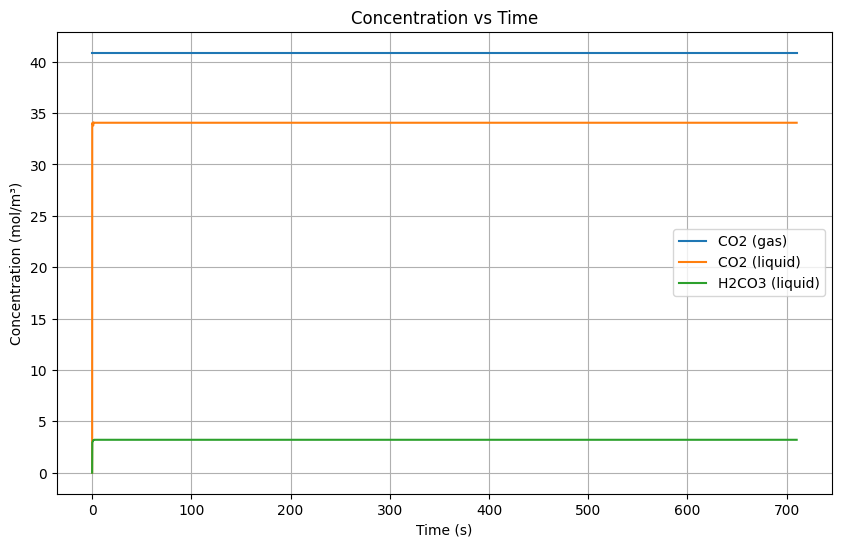

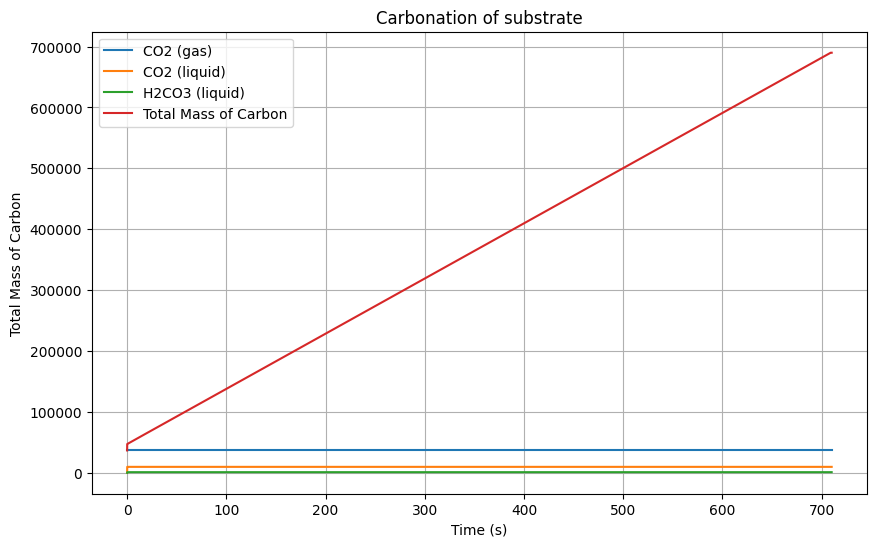

In [6]:
# Print final concentrations and mass transfer rate at the end of the simulation
H2CO3_values.append(H2CO3_new)
final_mass_transfer_rate = k * available_surface_area * (C_g_values[-1] - C_l_values[-1])



# Final total moles of carbon in the system
final_moles_CO2_gas = C_g_values[-1] * gas_volume
final_moles_CO2_liquid = C_l_values[-1] * liquid_volume
final_moles_H2CO3 = H2CO3_values[-1] * liquid_volume
final_total_moles_carbon = final_moles_CO2_gas + final_moles_CO2_liquid + final_moles_H2CO3 + cumulative_removal_values[-1]

# Print initial and final total moles of carbon
#print(f"Initial total moles of carbon: {initial_total_moles_carbon:.6f} mol")
#print(f"Final total moles of carbon: {final_total_moles_carbon:.6f} mol")

print(f"Final concentration of CO2 in the gas phase: {C_g_values[-1]:.6f} mol/m³")
print(f"Final concentration of CO2 in the liquid phase: {C_l_values[-1]:.6f} mol/m³")
#print(f"Final mass transfer rate: {final_mass_transfer_rate:.6f} mol/s")
print(f"Final concentration of HCO3- in the liquid phase: {H2CO3_values[-1]:.6f} mol/m³")


# Print cumulative total moles of carbon removed
#print(f"Cumulative total moles of carbon removed: {cumulative_removal_values[-1]:.6f} mol")
print(f"Cumulative total mass of carbon removed: {cumulative_mass_removed [-1]:.6f} kg")

print(f"Time to reach CO2 removal target: {time_points [-1]:.6f} sec")

print(f"Time to reach CO2 removal target: {(1/60)*time_points [-1]:.6f} minutes")

print(f"Time to reach CO2 removal target: {(1/3600)*time_points [-1]:.6f} hours")
print(f"Maximum CO2 flow rate: {C_flow_values[-1]:.6f} m3/s")



time_points.append(time_points[-1] + time_step)  # Increment time by the time step
C_g_values.append(C_g_new)
C_l_values.append(C_l_new)
C_sol_values.append(C_sol_new)
cumulative_removal_values.append(cumulative_removal_values[-1])
total_moles_carbon_values.append(total_moles_carbon)
C_flow_values.append(C_flow_values)
C_flow_values.append(C_flow_values)


# Plot the results
#plt.figure(figsize=(10, 6))
#plt.plot(time_points, C_g_values, label='CO2 concentration in gas phase')
#plt.plot(time_points, C_l_values, label='CO2 concentration in liquid phase')
#plt.plot(time_points, C_sol_values, label='CO2 solubility in liquid phase')
#plt.xlabel('Time (seconds)')
#plt.ylabel('CO2 concentration (mol/m³)')
#plt.title('CO2 Concentration in Gas and Liquid Phases Over Time')
#plt.legend()
#plt.grid(True)
#plt.show()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, C_g_values, label="CO2 (gas)")
plt.plot(time_points, C_l_values, label="CO2 (liquid)")
plt.plot(time_points,H2CO3_values, label="H2CO3 (liquid)")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (mol/m³)")
plt.legend()
plt.title("Concentration vs Time")
plt.grid(True)
plt.show()

# Plot results
#plt.figure(figsize=(10, 6))
#plt.plot(time_points, [val * gas_volume for val in C_g_values], label="CO2 (gas)")
#plt.plot(time_points, [val * liquid_volume for val in C_l_values], label="CO2 (liquid)")
#plt.plot(time_points, [val * liquid_volume for val in H2CO3_values], label="H2CO3 (liquid)")
#plt.plot(time_points, cumulative_removal_values, label="Cumulative Removal")
#plt.plot(time_points, total_moles_carbon_values, label="Total Moles of Carbon")
#plt.xlabel("Time (s)")
#plt.ylabel("Total Moles of Carbon")
#plt.legend()
#plt.title("Total Moles of Carbon vs Time")
#plt.grid(True)
#plt.show()


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, [val * gas_volume for val in C_g_values], label="CO2 (gas)")
plt.plot(time_points, [val * liquid_volume for val in C_l_values], label="CO2 (liquid)")
plt.plot(time_points, [val * liquid_volume for val in H2CO3_values], label="H2CO3 (liquid)")
#plt.plot(time_points, cumulative_removal_values, label="Cumulative Removal")
plt.plot(time_points, total_moles_carbon_values, label="Total Mass of Carbon")
plt.xlabel("Time (s)")
plt.ylabel("Total Mass of Carbon")
plt.legend()
plt.title("Carbonation of substrate")
plt.grid(True)
plt.show()


